# Introduction to Stochastic Programming - Newsvendor Problem
Prepared by: Nickolas Freeman, Ph.D.

This notebook demonstrates the use of kernel density estimataton and stochastic programming in the context of sourcing decisions. Specifically, it shows how the two tools may be combined to solve a *newsvendor problem* when demand follows a bimodal distribution. A description of the newsvendor problem, copied from Wikipedia on 1/3/2018, follows:

>The newsvendor (or newsboy or single-periodor perishable) model is a mathematical model in operations management and applied economics used to determine optimal inventory levels. It is (typically) characterized by fixed prices and uncertain demand for a perishable product. If the inventory level is $q$, each unit of demand above $q$ is lost in potential sales. This model is also known as the Newsvendor Problem or Newsboy Problem by analogy with the situation faced by a newspaper vendor who must decide how many copies of the day's paper to stock in the face of uncertain demand and knowing that unsold copies will be worthless at the end of the day.
>
>The standard newsvendor profit function is $\mathbb{E}[Profit] =\mathbb{E}\left[p\min(q,D)\right]-cq$, where $D$ is a random variable with probability distribution $F$ representing demand, each unit is sold for price $p$ and purchased for price $c$, $q$ is the number of units stocked, and $\mathbb{E}$ is the expectation operator. The solution to the optimal stocking quantity of the newsvendor which maximizes expected profit is:
>
> $$q=F^{-1}\left(\frac{p-c}{p}\right),$$ 
> where $F^{-1}$ denotes the inverse cumulative distribution function of $D$.
>
>Intuitively, this ratio, referred to as the critical fractile, balances the cost of being understocked (a lost sale worth $(p-c)$) and the total costs of being either overstocked or understocked (where the cost of being overstocked is the inventory cost, or $c$ so total cost is simply $p$).
>
>The critical fractile formula is known as Littlewood's rule in the yield management literature.

For the purpose of demonstration, we will begin by randomly generating some demand data for a single product. The following code block imports the several libraries we will be using and sets some defaults.

In [1]:
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set pandas default display format for floating-point numbers
pd.set_option('display.float_format','{:20,.2f}'.format)

# Set the default columns to display for pandas
pd.set_option('max_columns', 50)


import distribution_fitting as dist_fit

The following code block generates the demand data and plots it using a histogram.

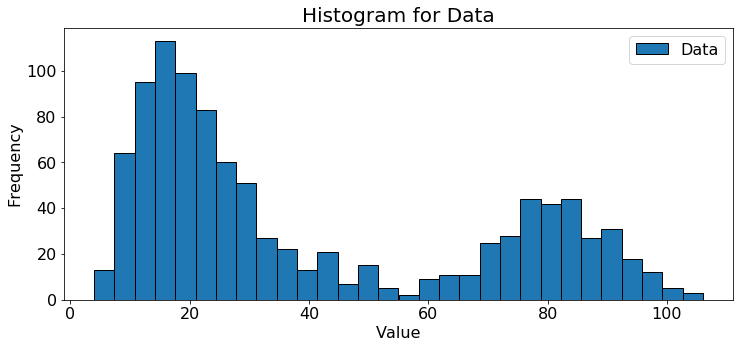

In [2]:
num_bins = 30
np.random.seed(42)
sample_size = 1000

dist_A = np.random.lognormal(3, 0.50, sample_size)
dist_B = np.random.normal(80, 10, sample_size)

random_numbers = np.random.rand(sample_size)
random_numbers > 0.7

data = dist_A[random_numbers <= 0.7]
data = np.append(data, dist_B[random_numbers > 0.7])
np.random.shuffle(data)

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.hist(data, bins = num_bins, label = 'Data', edgecolor = 'k', density = False)
ax.set_xlabel("Value", fontsize = 16)
ax.set_ylabel('Frequency', fontsize = 16)
ax.set_title('Histogram for Data', fontsize = 20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(fontsize = 16,loc=1)
plt.show()

The following code block uses the functions available in the `pyopsmgmt` package to fit a kernel density estimat for the data and randomly generates a sample comprised of 10,000 points. This sample is stored in an object named `benchmark` because we will use this sample as a point of comparison during our discussion of stochastic programming. 

In [3]:
best_params = dist_fit.fit_best_kde(data)
pdf = dist_fit.pdf_from_kde(data, 
                            bandwidth = best_params['bandwidth'],
                            kernel= best_params['kernel'])
benchmark = dist_fit.trunc_kde_sample(pdf['x'], 
                                      pdf['y'], 
                                      sample_size = 10000)

The following code block plots the original data sample and our benchmark sample just to demonstrate the fit.

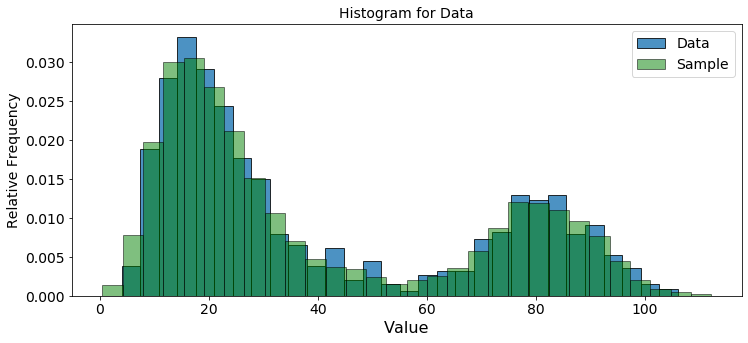

In [4]:
num_bins = 30

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.hist(data, bins = num_bins, label = 'Data', alpha = 0.8, edgecolor = 'k', density = True)
ax.hist(benchmark, bins = num_bins, label='Sample', alpha = 0.5, color = 'g', edgecolor = 'k', density = True)
ax.set_xlabel("Value", fontsize = 16)
ax.set_ylabel('Relative Frequency', fontsize = 14)
ax.set_title('Histogram for Data', fontsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
ax.yaxis.set_tick_params(labelsize = 14)
ax.legend(fontsize = 14)
plt.show()

We will turn our attention to solving a newsvendor problem using the demand data. The following code block computes the critical fractile for our example case, where we assume the unit cost equals $\$15$ and the selling price is $\$20$.

In [5]:
unit_cost = 15             # The unit cost the newsvendor pays for each unit of product
sale_price = 20            # The price that the newsvendor sells each unit of product at

Critical_Fractile = (sale_price-unit_cost) / sale_price
print(f'The critical fractile is {Critical_Fractile}')

The critical fractile is 0.25


The critical fractile corresponds to a percentile of the demand distribution. Thus, we need to determine the cumulative distribution function (CDF) for the demand data in order to translate the value to a specific order quantity. The next code block creates two objects that capture the CDF for the data.

In [6]:
cdfx = pdf['x'].copy()
cdfy = pdf['y'].cumsum()

To solve the newsvendor problem using the critical fractile, we need to be able to identify the smallest demand value where the associated value of the CDF is greater than or equal to the critical fractile. The following code block shows how we can use `Numpy`'s `argmax` function to identify such a value in the previously generated CDF. 

In [7]:
CF_index = np.argmax(cdfy > Critical_Fractile)
for i in range(CF_index -2, CF_index +3, 1):
    if (i == CF_index):
        print('----------------------------------------------------------------------------')
        print(f'The value in position {i}, which is {np.round(cdfx[i], 2)}, has a CDF of {np.round(cdfy[i], 3)}.')
        print('    This is the optimal value!!!')
        print('----------------------------------------------------------------------------')
    else:
        print(f'The value in position {i}, which is {np.round(cdfx[i], 2)}, has a CDF of {np.round(cdfy[i], 3)}.')

The value in position 140, which is 16.29, has a CDF of 0.244.
The value in position 141, which is 16.4, has a CDF of 0.247.
----------------------------------------------------------------------------
The value in position 142, which is 16.52, has a CDF of 0.251.
    This is the optimal value!!!
----------------------------------------------------------------------------
The value in position 143, which is 16.64, has a CDF of 0.254.
The value in position 144, which is 16.75, has a CDF of 0.258.


The following code block plots the location of the optimal value along with the CDF for the KDE. 

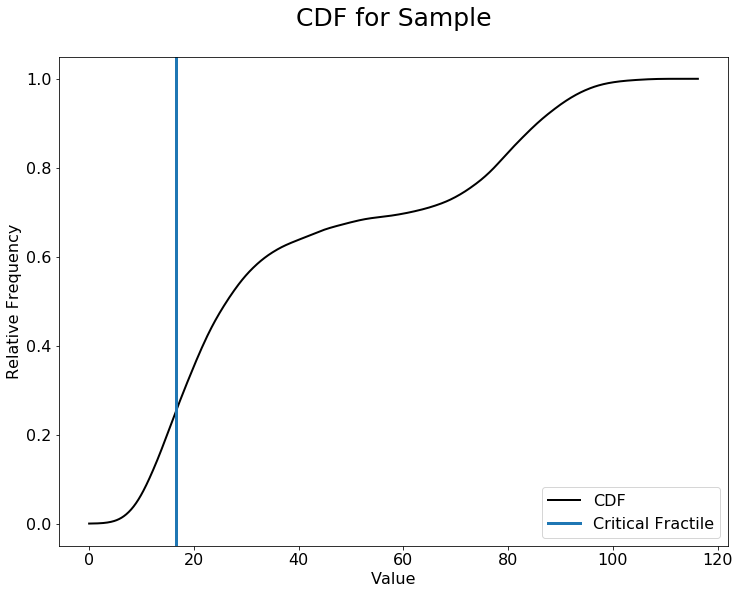

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12,9))
ax.plot(cdfx, cdfy, color = 'k', linewidth = 2, label='CDF')
ax.axvline(cdfx[CF_index], label='Critical Fractile', linewidth=3)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(fontsize = 16)
ax.set_xlabel("Value",fontsize = 16)
ax.set_ylabel("Relative Frequency",fontsize = 16)
ax.set_title("CDF for Sample",fontsize=25,y=1.05)
plt.show()

The following code block plots the location of the optimal value along with the histogram for the benchmark sample. 

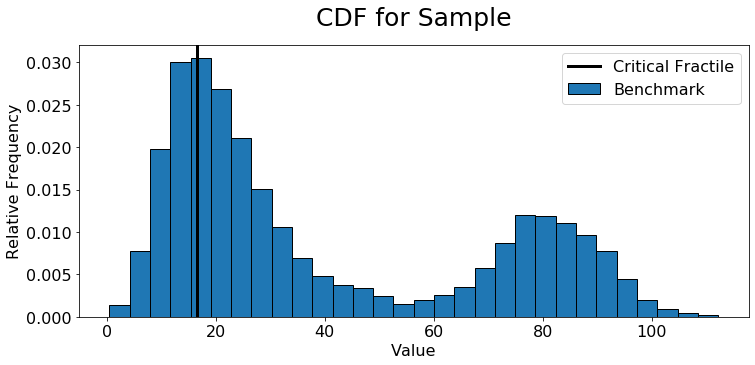

In [9]:
num_bins = 30

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.hist(benchmark, bins=num_bins, edgecolor = 'k', density=True, label= 'Benchmark')
ax.axvline(cdfx[CF_index], label='Critical Fractile', color = 'k', linewidth=3)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(fontsize = 16)
ax.set_xlabel("Value",fontsize = 16)
ax.set_ylabel("Relative Frequency",fontsize = 16)
ax.set_title("CDF for Sample",fontsize=25,y=1.05)
plt.show()

We will now build a stochastic programming (SP) model for solving the newsvendor problem. From https://en.wikipedia.org/wiki/Stochastic_programming (accessed 3/28/2018):

> In the field of mathematical optimization, stochastic programming is a framework for modeling optimization problems that involve uncertainty. Whereas deterministic optimization problems are formulated with known parameters, real world problems almost invariably include some unknown parameters. When the parameters are known only within certain bounds, one approach to tackling such problems is called robust optimization. Here the goal is to find a solution which is feasible for all such data and optimal in some sense. **Stochastic programming models** are similar in style but **take advantage of the fact that probability distributions governing the data are known or can be estimated. The goal here is to find some policy that is feasible for all (or almost all) the possible data instances and maximizes the expectation of some function of the decisions and the random variables.** More generally, such models are formulated, solved analytically or numerically, and analyzed in order to provide useful information to a decision-maker.

Specifically, we will use the following mathematical model.

<u>Sets</u><br>
$\Omega$ - set of scenarios<br>

<u>Indices</u><br>
$\omega$ - scenario index, $\omega \in \Omega$,<br>

<u>Parameters</u><br>
$p$  - unit sales price,<br>
$c$ - unit cost,<br>
$d_{\omega}$ - demand in scenario $\omega$,<br>

<u>Decision Variables</u><br>
$Q$ - order quantity,<br>
$S_{\omega}$ - amount sold in scenario $\omega$,<br>


$$\displaystyle Maximize \left(\sum_{\omega \in \Omega}pS_{\omega}\bigg/|\Omega|\right) - cQ$$
$$\displaystyle Subject~to,\hspace{7cm}~$$
$$\displaystyle S_{\omega} \leq Q, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \leq d_{\omega}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \geq 0, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle Q \geq 0.\hspace{1.8cm}~$$


We will use the Gurobi optimization software to solve the stochastic model. Gurobi is named for its founders: Zonghao **Gu**, Edward **Ro**thberg and Robert **Bi**xby. Bixby was also the founder of CPLEX, one of Gurobi's competitors, while Rothberg and Gu led the CPLEX development team for nearly a decade. Assuming that you have installed Gurobi and obtained a valid license, the following code block imports the `gurobipy` module that will allow us to model problems in Python and solve them with Gurobi. We also define some basic parameters for our problem (scenarios, sales price, and unit cost).

In [10]:
from gurobipy import *

# user-defined parameters
scenarios = 10          # The number of scenarios to generate for the stochastic programming model
unit_cost = 15          # The unit cost the newsvendor pays for each unit of product
sale_price = 20         # The price that the newsvendor sells each unit of product at

Recall that we have already generated a benchmark sample. We will now generate a different sample that we will use for the SP model. For now, we will only use a sample size of 10. The sample is generated in the following code block.

In [11]:
opt_sample = dist_fit.trunc_kde_sample(pdf['x'], 
                                       pdf['y'], 
                                       sample_size = scenarios)
opt_sample

array([29.20074099, 66.07976447, 34.08692076, 28.96806576, 22.56949702,
       41.64886563, 23.15118509, 84.69378263, 92.83741558, 21.05710804])

In the following code blocks, we will define and solve the Gurobi optimization model. The steps in creating and solving the model are:
1. Create a `model` object named *Newsvendor* (naming is optional)
2. Create variables for the newvendor's order quantity and the amount that the newsvendor sells in each scenario (or sample point)
4. Add sets of constraints that ensure the amount that the newsvendor sells in each scenario is less than $i$) the amount ordered and $ii$) demand
5. Specify an objective of maximizing *expected* profit
6. Optimize the model

The following code block creates a model named *Newsvendor* and stores it as an object `m`. The `help` function is them used to determine information about the Gurobi model.

In [12]:
m = Model(name = 'Newsvendor')
help(m)

Using license file C:\Users\nkfreeman\gurobi.lic
Academic license - for non-commercial use only

  Gurobi model object.  Commonly used methods on this object are:
    getConstrs(): Get a list of constraints in the model
    getJSONSolution(): Get a JSON-string representation of the current solution(s) to the model
    getParamInfo(paramname): Get information on a model parameter.
    getVars(): Get a list of variables in the model
    optimize(): Optimize the model.
    printAttr(attrname, filter): Print attribute values.
    printQuality(): Print solution quality statistics.
    printStats(): Print model statistics.
    read(filename): Read model data (MIP start, basis, etc.) from a file
    reset(): Discard any resident solution information.
    resetParams(): Reset all parameters to their default values.
    setParam(paramname, newval): Set a model parameter to a new value.
    write(filename): Write model data to a file.

  Models have a number of attributes that can be queried or 

As noted in the previous docstring, you can see all of the model attributes by running `help(GRB.attr)`.

In [13]:
help(GRB.attr)


  Attributes are used throughout the Gurobi interface to query and
  modify model properties.  You refer to them as you would any
  other object attribute.  For example, "print model.numConstrs"
  prints the number of constraints in a model.  You can assign new values to
  some attributes (e.g., model.ModelName = "New"), while others can only
  be queried.  Note that attribute modification is handled in a lazy fashion,
  so you won't see the effect of a change until after the next call to
  Model.update() or Model.optimize().

  Capitalization is ignored in Gurobi attribute names, so
  model.numConstrs and model.NumConstrs are equivalent.

  Gurobi attributes can be grouped into the following categories:

  General model attributes (e.g., model.numConstrs):

    numConstrs: Number of constraints
    numVars: Number of variables
    numSOS: Number of SOS constraints
    numQConstrs: Number of quadrtic constraints
    numGenConstrs: Number of general constraints
    numNZs: Number of no

The following code block demonstrates how we can query the values of our model's attributes.

In [14]:
print(f'Our newsvendor model currently has {m.numVars} variables and {m.numConstrs} constraints')

Our newsvendor model currently has 0 variables and 0 constraints


With our model object defined, we will now add variables to capture the newsvendor's order quantity and the amount sold in each scenario. The following code block provides information on the method we will use to add the order quantity variable.

In [15]:
help(m.addVar())


  Gurobi variable object.  Variables have a number of attributes.
  Some can be set (e.g., v.ub = 0.0), while others can only be queried
  (e.g., print(v.x)). The most commonly used variable attributes are:
    obj: Linear objective coefficient.
    lb: Lower bound.
    ub: Upper bound.
    varName: Variable name.
    vType: Variable type ('C', 'B', 'I', 'S', or 'N').
    x: Solution value.
    rc: Solution reduced cost.
    xn: Solution value in an alternate MIP solution.

  Type "help(GRB.attr)" for a list of all available attributes.

  Note that attribute modifications are handled in a lazy fashion.  You
  won't see the effect of a change until after the next call to Model.update()
  or Model.optimize().
  


The following code block adds the decision variables. Note that the only major difference between the `addVar` and `addVars` functions is that we need to specify the number of variables to create when using `addVars`.

In [16]:
Order = m.addVar(vtype = 'C', name="Order")
Sell = m.addVars(scenarios, vtype = 'C', name = "Sell")

The following code block shows that Gurobi stores the variables in a specialized container called a `tupledict`.

In [17]:
m.update()
type(Sell)

gurobipy.tupledict

As a result of this storage convention, we can simply use dictionary-style indexing to access a particular variable. The following code block accesses the variable at index 3, and uses the help function to show the associated docstring.

In [18]:
help(Sell[3])


  Gurobi variable object.  Variables have a number of attributes.
  Some can be set (e.g., v.ub = 0.0), while others can only be queried
  (e.g., print(v.x)). The most commonly used variable attributes are:
    obj: Linear objective coefficient.
    lb: Lower bound.
    ub: Upper bound.
    varName: Variable name.
    vType: Variable type ('C', 'B', 'I', 'S', or 'N').
    x: Solution value.
    rc: Solution reduced cost.
    xn: Solution value in an alternate MIP solution.

  Type "help(GRB.attr)" for a list of all available attributes.

  Note that attribute modifications are handled in a lazy fashion.  You
  won't see the effect of a change until after the next call to Model.update()
  or Model.optimize().
  


Just for informational purposes, you can create a set of variable one-at-a-time by first defining an empty `tuple_dict` instance, and then adding values using a loop. This is demonstrated below.

In [19]:
Sell_loop = tupledict()
for i in range(scenarios):
    Sell_loop[i] = m.addVar(vtype = 'C', name = 'Sell_loop')
m.update()
Sell_loop

{0: <gurobi.Var Sell_loop>,
 1: <gurobi.Var Sell_loop>,
 2: <gurobi.Var Sell_loop>,
 3: <gurobi.Var Sell_loop>,
 4: <gurobi.Var Sell_loop>,
 5: <gurobi.Var Sell_loop>,
 6: <gurobi.Var Sell_loop>,
 7: <gurobi.Var Sell_loop>,
 8: <gurobi.Var Sell_loop>,
 9: <gurobi.Var Sell_loop>}

The following code cell deletes the `Sell_loop` object that we used for demonstration if it still exists.

In [20]:
try:
    m.remove(Sell_loop)
    del(Sell_loop)
except NameError:
    print('Sell_loop already deleted!')

We will now add our constraints. Similar to the approach for adding variables, Gurobi offers an `addConstr` method to add individual constraints and an `addConstrs` method to add multiple constraints at once. Although the `addConstrs` method exists, I personally prefer to always use the `addConstr` method and build constraints using loops. The following code block builds the constraint set:

$$\displaystyle S_{\omega} \leq d_{\omega}, ~~~~\forall \omega \in \Omega.$$

Note how the code closely matches the formulation. Ultimately, **if you get the formulation right, coding it is easy!**

In [21]:
for scenario in range(scenarios):
    m.addConstr(Sell[scenario] <= opt_sample[scenario], name = 'Sell <= Demand') 

The following code block builds the constraint set:

$$\displaystyle S_{\omega} \leq Q, ~~~~\forall \omega \in \Omega.$$

In [22]:
for scenario in range(scenarios):
    m.addConstr( Sell[scenario] <= Order, name = 'Sell <= Order')

We will now turn our attention to defining the objective function:

$$\displaystyle Maximize \left(\sum_{\omega \in \Omega}pS_{\omega}\bigg/|\Omega|\right) - cQ.$$

We will begin by constructing the summation term using a `LinExpr()` object. These objects allow us to make expressions involving defined variables and parameters. They can also be used when constructing constraints.

In [23]:
total_sales = LinExpr()
for scenario in range(scenarios):
    total_sales.add(Sell[scenario])
    
m.update()
total_sales

<gurobi.LinExpr: Sell[0] + Sell[1] + Sell[2] + Sell[3] + Sell[4] + Sell[5] + Sell[6] + Sell[7] + Sell[8] + Sell[9]>

We can use the `total_sales` object to define our objective function and instruct the model that we wish to minimize its value.

In [24]:
objective =( (sale_price * total_sales) / scenarios) - unit_cost * Order
m.setObjective(objective, GRB.MAXIMIZE) # maximize profit
m.update()

If we would like to inspect the model in a relatively easy to read format, we can write it as an *lp* file.

In [25]:
m.write('model.lp')

Calling the `optimize()` method solves the model.

In [26]:
m.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 20 rows, 12 columns and 30 nonzeros
Model fingerprint: 0x8747be2b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 9e+01]
Presolve removed 10 rows and 1 columns
Presolve time: 0.00s
Presolved: 10 rows, 11 columns, 20 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1248283e+02   4.441188e+01   0.000000e+00      0s
       3    1.1040440e+02   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds
Optimal objective  1.104043952e+02


We can obtain the optimal value of a defined variable by using the `X` attribute.

In [27]:
Optimal_Quantity = Order.X

print(f'The optimal order quantity is {Order.X}')

The optimal order quantity is 23.151185087407


# All together

The following code block combines our previous code into a function that we can use to construct and solve the model.

In [28]:
def solve_newsvendor_model(sale_price, unit_cost, opt_sample):
    scenarios = len(opt_sample)
    
    m = Model(name = 'Newsvendor')
    m.Params.OutputFlag = 0

    Order = m.addVar(vtype = 'C', name="Order")
    Sell = m.addVars(scenarios, vtype = 'C', name = "Sell")

    for scenario in range(scenarios):
        m.addConstr(Sell[scenario] <= opt_sample[scenario], name = 'Sell <= Demand') 

    for scenario in range(scenarios):
        m.addConstr(Sell[scenario] <= Order, name = 'Sell <= Order')

    total_sales = LinExpr()
    for scenario in range(scenarios):
        total_sales.add(Sell[scenario])

    objective =( (sale_price * total_sales) / scenarios) - unit_cost * Order
    m.setObjective(objective, GRB.MAXIMIZE) # maximize profit

    m.optimize()

    return Order.X

The following code block demonstrates how the function can be used.

In [29]:
opt_sample = dist_fit.trunc_kde_sample(pdf['x'], 
                                       pdf['y'], 
                                       sample_size = 10)
solve_newsvendor_model(20, 15, opt_sample)

23.151185087407

The following code block defines an interactive visualization that we can use to observe how the stochastic programming solution compares to the theoretical solution as the number of scenarios that we include in our optimization model varies. As we increase the number of scenarios, the stochastin prgramming model is able to better approximate the underlying uncertainty, and as a result, the stochastic programming solution converges to the theoretical solution.

In [30]:
scenarios_list = [1, 2, 3, 4, 5, 10, 25, 50, 100, 250, 500, 750, 1000]

@interact(scenarios = scenarios_list)

def interactive_newsvendor(scenarios = scenarios_list[0]):
    opt_sample = dist_fit.trunc_kde_sample(pdf['x'], 
                                           pdf['y'], 
                                           sample_size = scenarios)
    SP_solution = solve_newsvendor_model(20, 15, opt_sample)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.hist(data, bins=100, alpha = 0.5, edgecolor = 'k', density=True, label= 'data')
    ax.axvline(cdfx[CF_index], label='Critical Fractile', color = 'k', linewidth=3)
    ax.axvline(SP_solution, label='SP Solution', color = 'k', linestyle = '--', linewidth=3)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.legend(fontsize = 16)
    ax.set_xlabel("Value",fontsize = 16)
    ax.set_ylabel("Relative Frequency",fontsize = 16)
    ax.set_title("Comparison of Stochastic Programming and Theoretical Solution", fontsize=16)
    plt.show()

interactive(children=(Dropdown(description='scenarios', options=(1, 2, 3, 4, 5, 10, 25, 50, 100, 250, 500, 750…

# Practical Application

In this section, we will use the model that we have built to approximate weekly order quantities for a liquor distributor. The data that we will use is a sample of the data posted by the state of Iowa at https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy (last verified on 3/4/2019). The following code block reads the data from my personal website and prints the shape of the data.

In [31]:
iowa = pd.read_csv('https://nkfreeman.people.ua.edu/uploads/1/2/3/6/123664668/iowa_liquor_sales.csv')
iowa.shape

(45528, 22)

As the previous code block shows, our data set includes a little over 45,528 records. The following code block uses the `head()` method to print the first three rows of the data.

In [32]:
iowa.head(3)

,bottle_volume_ml,category,category_name,city,county,county_number,date,im_desc,invoice_line_no,itemno,name,pack,sale_bottles,sale_dollars,sale_gallons,sale_liters,state_bottle_cost,state_bottle_retail,store,vendor_name,vendor_no,zipcode
0,200,"1,051,010.00",AMERICAN GRAPE BRANDIES,BURLINGTON,Des Moines,29.00,2015-11-20T00:00:00.000,Paul Masson Grande Amber Brandy,S29208400004,53213,Hy-Vee Food Store #1 / Burlington,24,24,70.56,1.27,4.80,1.96,2.94,2507,"Constellation Wine Company, Inc.",115,52601
1,375,"1,031,080.00",VODKA 80 PROOF,ADAIR,Adair,1.00,2014-09-29T00:00:00.000,Hawkeye Vodka,S21475300011,36304,KUM & GO #76 / ADAIR,24,24,74.64,2.38,9.00,2.07,3.11,4417,Luxco-St Louis,434,50002
2,1000,"1,062,310.00",SPICED RUM,HOLSTEIN,Ida,47.00,2013-10-30T00:00:00.000,Captain Morgan Spiced Rum,S15417300003,43337,"Spirits, Stogies and Stuff",12,12,211.44,3.17,12.00,11.75,17.62,3650,Diageo Americas,260,51025


We will be consider ing the stocking decisions for a distributor. Even though the previous output shows that the data includes information on vendors, we will assume that a single distributor serves all of the stores included in the data set. Our goal will be to determine newsvendor weekly stocking quantities for top products. 

**Note: Although we are considering newsvendor quantities, this problem does not exactly fit a typical newsvendor setting since the stocking item (liquor) is not perishable in the short-term. We are essentially assuming the items are perishable for demonstration purposes.**

First, we will convert the `date` column to a `datetime` object with the format *year-week*. For more information on formatting dates using `strftime` see https://docs.python.org/2/library/datetime.html#strftime-strptime-behavior.

In [33]:
iowa['date'] = pd.to_datetime(iowa['date']).dt.strftime('%Y-%U')

Let's suppose we only want to consider the top 10 items according to total sales. The following code block creates a list of the associated items and overwrites the `iowa` object so that it only includes items that belong to the top 10.

In [34]:
top_values = 10
top_selling_items = iowa.groupby(['itemno'])['sale_bottles'].sum()\
.reset_index().sort_values('sale_bottles', ascending = False).head(top_values)['itemno'].tolist()

iowa = iowa[iowa['itemno'].isin(top_selling_items)]

The following code block uses Pandas' `groupby` method to create a DataFrame object named `weekly_sales` that includes the weekly sales for the top 10 products.

In [35]:
weekly_sales = iowa.groupby(['itemno','date'])['sale_bottles'].sum().reset_index()
weekly_sales.head()

,itemno,date,sale_bottles
0,11297,2012-01,1
1,11297,2012-02,188
2,11297,2012-03,63
3,11297,2012-04,57
4,11297,2012-05,139


The following code block uses the `state_bottle_cost` and `state_bottle_retail` columns to determine the mean sales price and unit cost for items included in our data. We will use these averages as the sales price and unit cost in our newsvendor model.

In [36]:
bottle_costs = iowa.groupby(['itemno'])[['state_bottle_cost', 'state_bottle_retail']].mean().reset_index()
bottle_costs

,itemno,state_bottle_cost,state_bottle_retail
0,11297,18.15,27.22
1,11776,5.15,7.76
2,11788,10.10,15.32
3,26827,17.40,26.10
4,35317,3.97,5.95
5,36308,7.15,10.74
6,36904,1.79,2.68
7,37348,7.53,11.29
8,43336,8.69,13.05
9,43337,11.57,17.35


The following code block outlines a process for solving the order quantity problem for a single item. The steps are outlined in the comments.

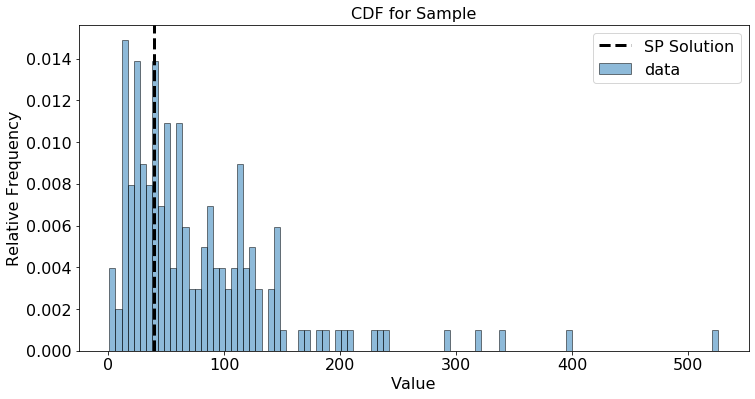

In [37]:
# Specify the current item
item = weekly_sales['itemno'].unique()[0]

# Get the weekly sales for the specified item as an array
item_sales = weekly_sales[weekly_sales['itemno'] == item]['sale_bottles'].values

# Remove outliers from the sales data
item_sales = dist_fit.handle_outliers(item_sales)

# Retrieve the mean unit cost from the 'bottle_costs' object
item_unit_cost = float(bottle_costs[bottle_costs['itemno'] == item]['state_bottle_cost'])

# Retrieve the mean sales price from the 'bottle_costs' object
item_sale_price = float(bottle_costs[bottle_costs['itemno'] == item]['state_bottle_retail'])

# Fit a KDE to the sales data and store the associated bandwidth and kernel type
best_params = dist_fit.fit_best_kde(item_sales)

# Approximate the probability density function (PDF) for the KDE
pdf = dist_fit.pdf_from_kde(item_sales, 
                            bandwidth = best_params['bandwidth'],
                            kernel= best_params['kernel'])

# Generate a sample from the KDE (in this case, we are using a sample size of 500)
sample = dist_fit.trunc_kde_sample(pdf['x'], 
                                   pdf['y'], 
                                   sample_size = 500)

# Solve the newsvendor model using the approximated sales price, 
# the approximated unit cost, and the generated sample
SP_solution = solve_newsvendor_model(item_sale_price, item_unit_cost, sample)

# Plot the solution along with the sales sample
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(item_sales, bins=100, alpha = 0.5, edgecolor = 'k', density=True, label= 'data')
ax.axvline(SP_solution, label='SP Solution', color = 'k', linestyle = '--', linewidth=3)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(fontsize = 16)
ax.set_xlabel("Value",fontsize = 16)
ax.set_ylabel("Relative Frequency",fontsize = 16)
ax.set_title("CDF for Sample", fontsize=16)
plt.show()

The following code block uses the previously developed code, minus the plotting, to repeat the order quantity determination for all products in the data. The order quantity, as well as information for each product, is used to create a Pandas `DataFrame`.

In [38]:
item_list = []
order_list = []
unit_cost_list = []
retail_price_list = []
mean_sales_list = []
std_sales_list = []

for item in top_selling_items:
    # Get the weekly sales for the specified item as an array
    item_sales = weekly_sales[weekly_sales['itemno'] == item]['sale_bottles'].values

    # Remove outliers from the sales data
    item_sales = dist_fit.handle_outliers(item_sales)

    # Retrieve the mean unit cost from the 'bottle_costs' object
    item_unit_cost = float(bottle_costs[bottle_costs['itemno'] == item]['state_bottle_cost'])

    # Retrieve the mean sales price from the 'bottle_costs' object
    item_sale_price = float(bottle_costs[bottle_costs['itemno'] == item]['state_bottle_retail'])

    # Fit a KDE to the sales data and store the associated bandwidth and kernel type
    best_params = dist_fit.fit_best_kde(item_sales)

    # Approximate the probability density function (PDF) for the KDE
    pdf = dist_fit.pdf_from_kde(item_sales, 
                                bandwidth = best_params['bandwidth'],
                                kernel= best_params['kernel'])

    # Generate a sample from the KDE (in this case, we are using a sample size of 500)
    sample = dist_fit.trunc_kde_sample(pdf['x'], 
                                       pdf['y'], 
                                       sample_size = 500)

    # Solve the newsvendor model using the approximated sales price, 
    # the approximated unit cost, and the generated sample
    SP_solution = solve_newsvendor_model(item_sale_price, item_unit_cost, sample)
    
    # Append information to lists
    item_list.append(item)
    order_list.append(SP_solution)
    unit_cost_list.append(item_unit_cost)
    retail_price_list.append(item_sale_price)
    mean_sales_list.append(np.array(item_sales).mean())
    std_sales_list.append(np.array(item_sales).std(ddof = 1))
    print(f'Item #{item} complete.')
 
# Create a dictionary containing item information and order quantities
item_dict = {'Item': item_list,
             'Mean Sales': mean_sales_list,
             'Std Sales': std_sales_list,
             'Unit Cost': unit_cost_list,
             'Retail Price': retail_price_list,
             'NV Order Quantity': order_list}

# Create a DataFrame from the dictionary
order_data = pd.DataFrame.from_dict(item_dict)

Item #11788 complete.
Item #36308 complete.
Item #43337 complete.
Item #36904 complete.
Item #35317 complete.
Item #11297 complete.
Item #43336 complete.
Item #26827 complete.
Item #37348 complete.
Item #11776 complete.


The following code block:
1. Adds a column named `NV to Mean` to the `order_data` object. This column expresses the newsvendor order quantity as a proportion of the mean weekly sales.
2. Adds a column named `Profit Margin` to the `order_data` object. This column captures the profit margin for each item based on our approximations of the unit cost and sales price.
3. Adds a column named `CV` to the `order_data` object. This column captures the coefficient of variation for each item. The coefficient of variation for a random variable is calculate by taking the ratio of the standard deviation to the mean.
4. Sorts the data by the `NV to Mean` column, from high to low.

The resulting `order_data` objects suggests that as the coefficient of variation increases, the corresponding newsvendor order quantity will be lower when expressed as a proportion of the mean demand/sales. This seems to suggest that higher degrees of variation may result in increasing conservatism. Is this correct, or is something else driving the observed changes?

In [39]:
order_data['NV to Mean'] = order_data['NV Order Quantity']/order_data['Mean Sales']
order_data['Profit Margin'] = order_data['Retail Price']/order_data['Unit Cost'] - 1.00
order_data['CV'] = order_data['Std Sales']/order_data['Mean Sales']
order_data = order_data.sort_values('NV to Mean', ascending = False)
order_data

,Item,Mean Sales,Std Sales,Unit Cost,Retail Price,NV Order Quantity,NV to Mean,Profit Margin,CV
9,11776,89.37,45.62,5.15,7.76,65.39,0.73,0.51,0.51
1,36308,150.75,94.29,7.15,10.74,104.36,0.69,0.50,0.63
6,43336,90.65,53.00,8.69,13.05,59.91,0.66,0.50,0.58
3,36904,141.01,86.81,1.79,2.68,92.34,0.65,0.50,0.62
0,11788,230.23,167.01,10.10,15.32,142.19,0.62,0.52,0.73
8,37348,40.80,33.94,7.53,11.29,23.17,0.57,0.50,0.83
2,43337,176.76,153.26,11.57,17.35,91.84,0.52,0.50,0.87
5,11297,77.32,70.93,18.15,27.22,39.38,0.51,0.50,0.92
7,26827,72.05,64.65,17.40,26.10,35.45,0.49,0.50,0.90
4,35317,130.56,156.13,3.97,5.95,40.36,0.31,0.50,1.20
